In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
import torch
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
%matplotlib inline

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [4]:
import data
import models
import paths
import routine
import viz_tools

# Train on LA5 dataset

Dataset size: 150
Labels distribution: (array([0, 1]), array([122,  28]))
Image shape: (1, 153, 189, 163)
Target: 0


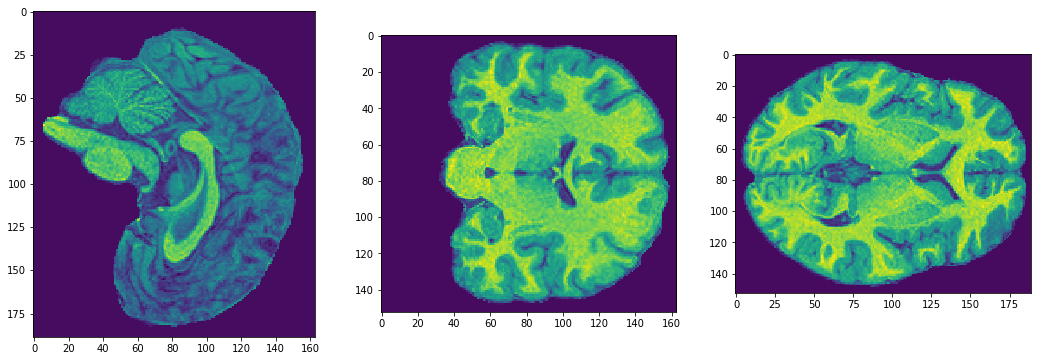

In [5]:
la5_dataset = data.LA5_Siblings_MRI(
    paths=paths.la5_data,
    target_path=paths.la5_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix=paths.la5_smri_file_suffix,
    brain_mask_suffix=paths.la5_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path=paths.la5_temp_npy_folder_path
)
print("Dataset size: {}".format(len(la5_dataset)))
print("Labels distribution: {}".format(np.unique(la5_dataset.labels, return_counts=True)))
img, target = la5_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

In [6]:
def create_model_opt():
    # reproducibility
    torch.manual_seed(0)
    np.random.seed(0)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    model = models.VoxResNet(num_classes=2, n_filters=32, stride=2, n_blocks=4, input_shape=la5_dataset.img_shape, dropout=0., n_fc_units=128, n_flatten_units=23040)
    opt = torch.optim.Adam(model.parameters(), lr=3e-5)
    return model, opt

Epoch 10 of 100 took 45.307s
  training loss (in-iteration): 	0.002472
  validation loss: 			0.406181
  training roc_auc_score: 			1.00
  validation roc_auc_score: 			0.90


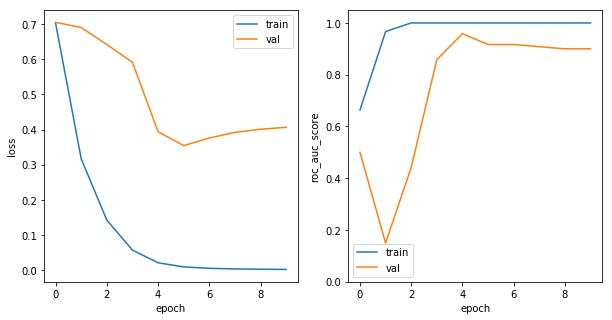

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
val roc_auc_scores: [0.7866666666666667, 0.88, 0.673611111111111, 0.6833333333333333, 0.9583333333333333]
val roc_auc_score mean: 0.7963888888888888
val roc_auc_score std: 0.1106049582528896
CPU times: user 32min 49s, sys: 16min 58s, total: 49min 47s
Wall time: 38min 24s


In [7]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, la5_dataset, cv, device, metric, batch_size=10)
print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

### train on whole LA5 dataset and save

In [8]:
model_save_path = "./models/conv_pretrained_la5.pth"

Epoch 7 of 100 took 147.450s
  training loss (in-iteration): 	0.002107
  training roc_auc_score: 			1.00


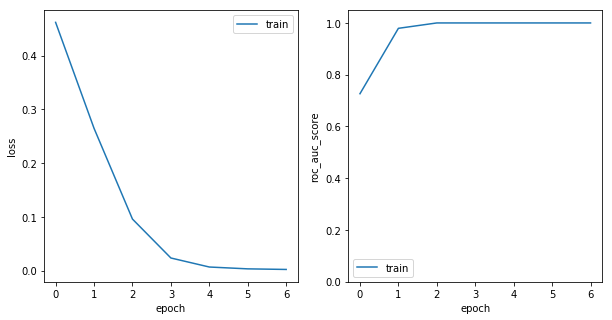

<Figure size 720x360 with 0 Axes>

Early stopping! Train loss < eps.
CPU times: user 5min 57s, sys: 3min 8s, total: 9min 6s
Wall time: 9min 34s


In [9]:
%%time
model, optimizer = create_model_opt()
metric = roc_auc_score
train_idx = np.arange(len(la5_dataset))
np.random.seed(0)
np.random.shuffle(train_idx)
train_idx = routine.stratified_batch_indices(train_idx, la5_dataset.labels[train_idx])
train_loader = DataLoader(Subset(la5_dataset, train_idx),
                          shuffle=False,
                          batch_size=10,
                          drop_last=False)
_ = routine.train(model, optimizer, train_loader, None, device, metric, verbose=1, model_save_path=model_save_path)

In [10]:
del model, optimizer, train_loader

# Test on Siblings dataset (without domain adaptation)

Dataset size: 64
Labels distribution: (array([0, 1]), array([41, 23]))
Image shape: (1, 153, 189, 163)
Target: 1


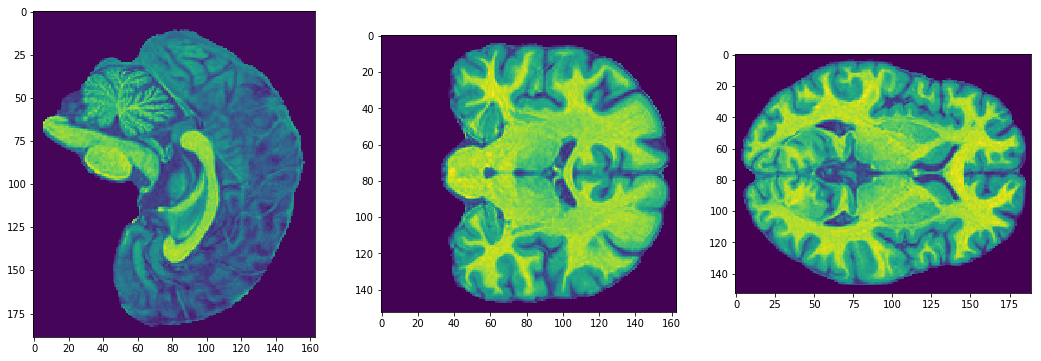

In [11]:
sibl_dataset = data.LA5_Siblings_MRI(
    paths=paths.sibl_data,
    target_path=paths.sibl_target_path,
    load_online=True,
    mri_type="sMRI",
    mri_file_suffix=paths.sibl_smri_file_suffix,
    brain_mask_suffix=paths.sibl_smri_brain_mask_suffix,
    coord_min=(20,20,0),
    img_shape=(153, 189, 163),
    problems=['Schz/Control'],
    temp_storage_path=paths.sibl_temp_npy_folder_path,
)
print("Dataset size: {}".format(len(sibl_dataset)))
print("Labels distribution: {}".format(np.unique(sibl_dataset.labels, return_counts=True)))
img, target = sibl_dataset[0]
print("Image shape: {}".format(img.shape))
print("Target: {}".format(target))
viz_tools.plot_central_cuts(img)

In [12]:
%%time
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
metric = roc_auc_score
val_metrics = routine.cross_val_score(create_model_opt, sibl_dataset, cv, device, metric, model_load_path=model_save_path)

# for transfer learning
# freeze layers in a create_model_opt
# val_metrics = routine.cross_val_score(create_model_opt,sibl_dataset, cv, device, metric, model_load_path=None)

print("val {}s: {}".format(metric.__name__, val_metrics))
print("val {} mean: {}".format(metric.__name__, np.mean(val_metrics)))
print("val {} std: {}".format(metric.__name__, np.std(val_metrics)))

100%|██████████| 2/2 [03:48<00:00, 114.37s/it]

val roc_auc_scores: [0.65]
val roc_auc_score mean: 0.65
val roc_auc_score std: 0.0
CPU times: user 7.5 s, sys: 4.23 s, total: 11.7 s
Wall time: 3min 49s


# Test on one another dataset (without domain adaptation)

In [13]:
# insert here

# Conclusion

One can notice a significant drop in performance. This problem we aim to solve.